<a href="https://colab.research.google.com/github/IGardocki/PythonIntro/blob/main/Final_Projectv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing:
### The METABRIC dataset contains three separate sections of data: 31 clinical features, z-scores for levels of 331 different types of mRNA, and information about specific genetic mutations that patients had in 175 specific genes. I will read in the dataset and perform appropriate preprocessing. Please see detailed description in comments for each step of preprocessing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Needed if working locally and not on Colab
# !pip3 install torch torchvision torchaudio
# !pip install torch-summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import svm
from torchsummary import summary
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
torch.cuda.empty_cache()

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

%matplotlib inline

In [ ]:
# read in data and visualize it
original_df=pd.read_csv("/content/drive/MyDrive/Spring Semester/ML for Molecular Bio/Datasets/METABRIC_RNA_Mutation.csv") # shape (1904, 693)
original_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# perform preprocessing

# gets rid of samples with nan values
no_nans_df = original_df.dropna() # shape (1092, 693)

# reduces dataset so that we are only looking at survival based on cancer
cancer_dependant_df = no_nans_df[no_nans_df['death_from_cancer'].str.contains('Died of Other Causes')==False]

# takes out death from cancer since that is what model will predict
cancer_dependant_df_2 = cancer_dependant_df.drop(['death_from_cancer'], axis=1) #shape (854, 692)
cancer_dependant_df_2.shape

# cuts off data section containing specfic mutations
no_muts_stop = cancer_dependant_df_2.columns.get_loc("pik3ca_mut")
no_muts = cancer_dependant_df_2.iloc[:, :no_muts_stop] # shape (854, 519)

# creates df of specific mutations, and converts 0s to strings so that all datatypes in df will be string
muts_df = cancer_dependant_df_2.iloc[:, no_muts_stop:].applymap(str) # shape (854,173)
muts_df.shape

#one hot encodes df with specific mutations
muts_encoder = OneHotEncoder()
muts_encoder.fit(muts_df)
preprocessed_muts = muts_encoder.transform(muts_df).toarray() # shape (854, 3675)
preprocessed_muts.shape

(854, 3675)

In [ ]:
# this will be our y 
overall_survival = no_muts['overall_survival'].values#.reshape(-1,1) # shape (854, 1)
overall_survival.shape

# drops overall survival since we will try to predict this, also drops overall survival months since it does not provide useful clinical predictive power
no_muts_2 = no_muts.drop(['overall_survival', 'overall_survival_months'], axis=1) # shape (854, 517)
no_muts_2.shape

# creates df of all mrna data
rna_df_start = cancer_dependant_df_2.columns.get_loc("brca1")
rna_df = no_muts_2.iloc[:, rna_df_start:] # shape (854, 487)

# scales rna feats
rna_scaler = StandardScaler()
preprocessed_rna_feats = rna_scaler.fit_transform(rna_df) # shape (854, 494)
preprocessed_rna_feats.shape

(854, 487)

In [ ]:
# Isolates clinical features and removes patient id
clin_stop=no_muts_2.columns.get_loc('brca1')
original_df_clinical_attributes = no_muts_2.iloc[:, 1:clin_stop] # shape (854, 27)
original_df_clinical_attributes.shape

# take non-cat features out of clinical attributes portion of dataset
cat_clin_feats = original_df_clinical_attributes.drop(['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'tumor_size'], axis=1) # shape (854, 22)
cat_clin_feats.shape

# one-hot encodes cat feats
clin_encoder = OneHotEncoder()
clin_encoder.fit(cat_clin_feats)
cat_clin_feats_encoded = clin_encoder.transform(cat_clin_feats).toarray() # shape (854, 78)
cat_clin_feats_encoded.shape

# creates array of quantitative clinical feats
quan_clin_feats=original_df_clinical_attributes[['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'tumor_size']] # shape (854, 5)
quan_clin_feats.shape
clin_scaler = StandardScaler()
quan_clin_feats_scaled = clin_scaler.fit_transform(quan_clin_feats)

# creates array of all clinical feats
preprocessed_clin_feats = np.hstack((cat_clin_feats_encoded, quan_clin_feats_scaled)) #shape(854, 83)
preprocessed_clin_feats.shape

(854, 83)

In [ ]:
# creates full preprocessed dataset
preprocessed_full = np.hstack((preprocessed_clin_feats, preprocessed_rna_feats, preprocessed_muts)) # shape (854, 4245)
preprocessed_full.shape

(854, 4245)

# Part 1: Comparison of Log Reg, SVM, Random Forests, Naive Bayes, and K Means
### In this section, I test four different variations of the dataset with several different models, keeping differing amounts of variation. Dataset variations include 1) Only clinical features, 2) Only RNA features, 3) Only mutation information, 4) All data. Models tested include: Logistic Regression, SVM, Random Forests, Naive Bayes, and K-Means. I experimented with keeping the following amounts of data variance: 0.99, 0.9, 0.7, 0.5, 0.3, and 0.1. For each dataset, I run 50 trials to see which model and level of variance yield the best result of prediction.

In [ ]:
def log_reg(X_train_in, X_test_in, y_train_in, y_test_in): 
    """
    Takes in split data, returns accuracy of logistic regression on test data

    """

    lr = LogisticRegression().fit(X_train_in, y_train_in)
    lr_train_acc = lr.score(X_train_in, y_train_in)
    lr_test_acc = lr.score(X_test_in, y_test_in)
    return ['Logistic Regression',lr_test_acc]

In [ ]:
def spt_vector_machine(X_train_in, X_test_in, y_train_in, y_test_in):
    """
    Takes in split data, returns accuracy of svm prediction of test data

    """ 
    SVM = svm.LinearSVC()
    SVM.fit(X_train_in, y_train_in)
    svm_train_acc = SVM.score(X_train_in,y_train_in)
    svm_test_acc = SVM.score(X_test_in,y_test_in)
    return ['SVM',svm_test_acc]

In [ ]:
def random_forest(X_train_in, X_test_in, y_train_in, y_test_in):
    """
    Takes in split data, returns accuracy of ransom forest prediction of test data

    """ 
    clf = RandomForestClassifier()
    clf.fit(X_train_in, y_train_in)
    random_forest_train_acc =  clf.score(X_train_in, y_train_in)
    random_forest_test_acc = clf.score(X_test_in, y_test_in)
    return['Random Forest', random_forest_test_acc]

In [ ]:
def naive_bayes_func(X_train_in, X_test_in, y_train_in, y_test_in):
  """
  Takes in split data, returns accuracy of naive bayes prediction of test data

  """ 
  nb = GaussianNB()
  nb.fit(X_train_in, y_train_in)
  y_pred=nb.predict(X_test_in)
  nb_test_acc=metrics.accuracy_score(y_pred, y_test_in)
  return ['Naive Bayes', nb_test_acc]

In [ ]:
def validate(y_hat,y):
    """
    prints accuracy of prediction of k means for survival classification.
    yhat: predictions
    y: overall survival ground truth
    """
    # correct classification
    survival = np.unique(y) 
    clusters =[np.where((y==s)) for s in survival]
    pred_class = np.unique(y_hat)
    
    assert len(pred_class) == len(survival), f'y_hat has less or more than {len(survival)} classes:{pred_class}'

    correct = 0
    total = 0
    for i in range(2):
        #loop over solutions
        counts=[]
        scores=[]
        for j in range(2):
            #loop over clusters of true assignments
            sol_i= np.where((y_hat==pred_class[i]))
            counts.append(len(np.intersect1d(sol_i, clusters[j])))
            scores.append(counts[-1]/len(clusters[j]))
        idx = np.argmax(scores)
        correct += counts[idx]
        total += np.count_nonzero(clusters[idx])

    acc = correct/total

    return acc

In [ ]:
def kmeans_func(X_in, y_in, num_clusters=2, draw_graph=False):
  """
  Takes in X and y data, performs k means clustering, and returns accuracy of clusters
  """
  kmeans = KMeans(n_clusters=num_clusters)
  label=kmeans.fit_predict(X_in)

  u_labels = np.unique(label)
  
  # provides option to draw graph, but will create lengthy output so I silence it
  if draw_graph:
  #plotting the results:
    fig_dims=(7,6)
    fig, ax = plt.subplots(figsize=fig_dims)
  
    for i in u_labels:
      sc=ax.scatter(X_in[label == i , 0] , X_in[label == i , 1] , label = i)

    plt.title("K Means 2")
    plt.legend()
    plt.show()

  k_means_test_acc = validate(label, y_in)
  return ['K Means', k_means_test_acc]

In [ ]:
def tester(name, Xs, ys): 
  """
  Takes in name of dataset, Xs, and ys

  Tests logistic regression, svm, random forest, naive bayes and kmeans to see which gives best results, while also testing each for 6 different pca values (given in n_comps_list)

  Returns the name of the best model, the accuracy it achieves, and the pca value it uses.
  """

  X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2)

  # creates list of pca values to test
  n_comp_list = [0.99, 0.9, 0.7, 0.5, 0.3, 0.1]

  # tracks best accuracy, best model, and best number of components
  best_acc = 0
  best_model= ""
  best_n_comp = 0

  # creates arrays to store results of each model 
  lr_results_arr=[]
  svm_results_arr=[]
  random_forest_results_arr=[]
  nb_results_arr=[]
  k_means_results_arr=[]

  # iterates through the n_comp list
  for comp in n_comp_list:
    # performs pca for comp value
    pca = PCA(n_components=comp)
    X_train_pca = pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # tests logisitc regression
    lr_results = log_reg(X_train_pca, X_test_pca, y_train, y_test)
    lr_results_arr.append(lr_results)

    # tests svm
    svm_results = spt_vector_machine(X_train_pca, X_test_pca, y_train, y_test)
    svm_results_arr.append(svm_results)

    # tests random forest
    random_forest_results = random_forest(X_train_pca, X_test_pca, y_train, y_test)
    random_forest_results_arr.append(random_forest_results)

    # tests naive bayes
    nb_results= naive_bayes_func(X_train_pca, X_test_pca, y_train, y_test)
    nb_results_arr.append(nb_results)

    # combines all Xs together and all Ys together to test K Means
    all_Xs = np.vstack((X_train_pca, X_test_pca))
    all_ys = np.concatenate((y_train, y_test), axis=0)

    # tests K Means
    k_means_results = kmeans_func(all_Xs, all_ys)
    k_means_results_arr.append(k_means_results)

    # tests if the result for any of the models is better than the current best result and updates if so
    for result in [lr_results, svm_results, random_forest_results, nb_results, k_means_results]:
      if result[1] > best_acc:
        best_acc = result[1]
        best_n_comp = comp
        best_model = result[0]
  
  return best_model, best_acc, best_n_comp

In [ ]:
def best_checker(name, Xs, ys, test_size):
  """
  Takes in name of dataset, X values and y values, and then the number of test trials (given by user).

  Runs tester function for number of test trials, then calculates the proportions at which models and pcs are chosen,
  as well as average accuracy of each model and pc combination
  """
  # creates array to stores
  scores_arr = []

  # creates arrays to store best models, accs, number of pcs, and best overall
  best_models = []
  best_accs = []
  best_n_comps = []
  best_overall = []

  # runs tester for given number of trials
  for i in range(test_size):
    new_model, new_acc, new_n_comp = tester(name, Xs, ys)
    best_models.append(new_model)
    best_accs.append(new_acc)
    best_n_comps.append(new_n_comp)
    best_overall.append((new_model + " " + str(new_n_comp), new_acc))

  # for each unique items in best overall array, gets the name, indices where it occurs, and number of times it occurs
  model, indices, counts = np.unique(np.asarray(best_overall)[:,0], return_index=True, return_counts=True)

  for i in range(len(model)):
    # adds to scores arr: name of model and pcs, proportion of times it was chosen in trials, and average accuracy when it was the best model
    scores_arr.append((model[i], counts[i]/test_size, np.average(np.asarray(best_accs)[indices[i]])))

  return np.asarray(scores_arr)

In [ ]:
# runs best checker on preprocessed clin feats for 50 trials
clin_unsorted_test_score = best_checker('Clin', preprocessed_clin_feats, overall_survival, 50)
# sorts results by models chosen most frequently
clin_test_score=clin_unsorted_test_score[clin_unsorted_test_score[:,1].argsort()[::-1]]

In [ ]:
# visualize top models for preprocessed_clin_feats
clin_df= pd.DataFrame(clin_test_score, columnsb=['Model/PCs', 'Freq Chosen', 'Avg Acc'])
clin_df

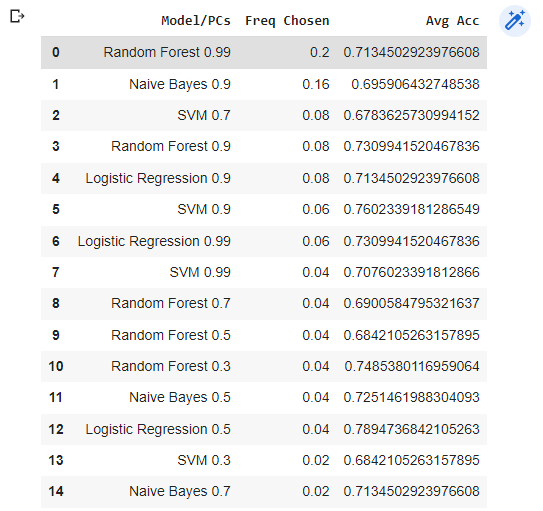

In [ ]:
# runs best checker on preprocessed rna feats for 50 trials
rna_unsorted_test_score = best_checker('RNA', preprocessed_rna_feats, overall_survival, 50)
rna_test_score=rna_unsorted_test_score[rna_unsorted_test_score[:,1].argsort()[::-1]]

In [ ]:
# visualize top models for preprocessed rna feats
rna_test_score_df= pd.DataFrame(rna_test_score, columns=['Model/PCs', 'Freq Chosen', 'Avg Acc'])
rna_test_score_df

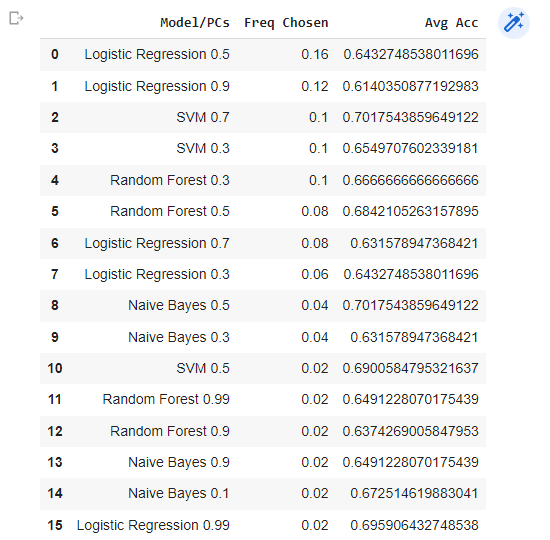

In [ ]:
muts_unsorted_test_score=best_checker('Mutations', preprocessed_muts, overall_survival, 50)
muts_test_score=muts_unsorted_test_score[muts_unsorted_test_score[:,1].argsort()[::-1]]

In [ ]:
# visualize top models for preprocessed muts
muts_test_score_df= pd.DataFrame(muts_test_score, columns=['Model/PCs', 'Freq Chosen', 'Avg Acc'])
muts_test_score_df

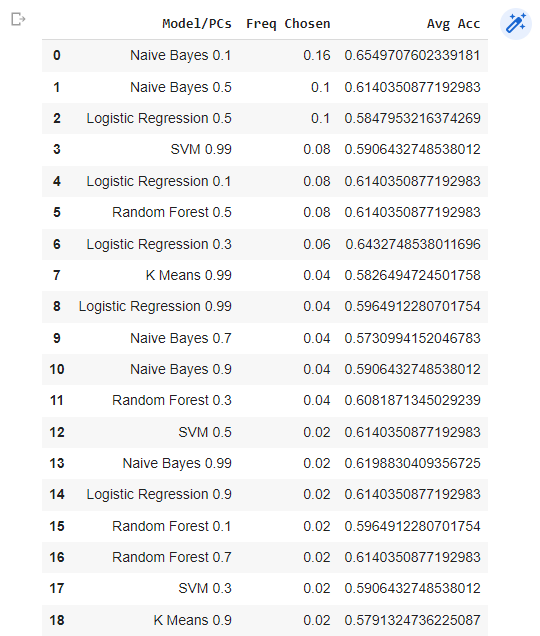

In [ ]:
# runs best checker on preprocessed full dataset for 50 trials
full_unsorted_test_score=best_checker('Full Dataset', preprocessed_full, overall_survival, 50)
full_test_score=full_unsorted_test_score[full_unsorted_test_score[:,1].argsort()[::-1]]

In [ ]:
# visualize top models for preprocessed full dataset
full_test_score_df= pd.DataFrame(full_test_score, columns=['Model/PCs', 'Freq Chosen', 'Avg Acc'])
full_test_score_df

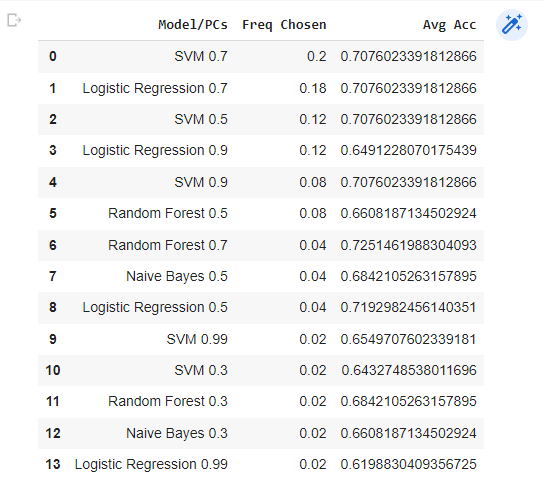

# Part 2: ANN Development
### Here I attempt to develop an ANN to predict survival since the models in part 1 did not predict as well as I would like. I experiment with varyng model architectures, as given in the 6 examples below (although I ran many more, tweaking various hyperparameters such as learning rate, batch size, early stopping, etc). It should be noted, that based on the results above, it is probably not likely that introducing a more complicated model will yield better results. However, for the sake of the project and my own desire to experiment, I made the attempt.

In [ ]:
# perform pca
full_pca=PCA(0.8)
dim_red_feats = full_pca.fit_transform(preprocessed_full)
dim_red_feats.shape

(854, 151)

In [ ]:
# get train test split
X_train, X_test, y_train, y_test = train_test_split(dim_red_feats, overall_survival, test_size=0.2, shuffle=True)

# convert to torch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# move to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# visualize data shapes
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: torch.Size([683, 151])
Y_train: torch.Size([683])
X_test:  torch.Size([171, 151])
Y_test:  torch.Size([171])


In [ ]:
# create timing function
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [ ]:
# implement trainer class that we have previously used

from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks
        # trainer = Trainer(model, optimizer, lr, epochs, batchsize) #, lambda x: x.reshape(input_shape))
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
        elif optimizer_type == 'adam_l2':
            self.optimizer = Adam(model.parameters(), learning_rate, weight_decay=1e-5)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,draw_curve=False,early_stop=False,l2=True,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        """
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
        outputs = torch.tensor(outputs, dtype=torch.int64)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float))
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, outputs, val_inputs, val_outputs = inputs.to(device), outputs.to(device), val_inputs.to(device), val_outputs.to(device)

        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                batch_predictions = self.model(batch_input)

                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                batch_input, batch_output, batch_predictions = batch_input.to(device), batch_output.to(device), batch_predictions.to(device)

                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    l2_lambda = 1e-5
                    l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.detach().cpu().item() * batch_importance
                acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
                epoch_acc += acc.detach().cpu().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1,losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1,val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
        
        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        if torch.is_tensor(inputs):
            inputs = self.input_transform(inputs)
        else:
            inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
            outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            batch_input, batch_output= batch_input.to(device), batch_output.to(device)
            
            with torch.no_grad():
                batch_predictions = self.model(batch_input.float())
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            batch_acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
            losses += loss.detach().cpu().item() * batch_importance
            acc += batch_acc.detach().cpu().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [ ]:
from sklearn.model_selection import train_test_split,KFold
def Kfold(model_func,k,Xs,ys,test_Xs,test_ys,epochs,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=1e-3,l2=True): # input_shape=(-1,1024)):
    """ Do Kfold cross validation with the specified arguments
    model_func: function. 
        Constructor of the model.
    k: int. The number of fold
    Xs: np.array, The shape of Xs.reshape(input_shape) should be (ndata,nfeatures)
    ys: np.array shape (ndata,)
    test_Xs: np.array, The shape of test_Xs.reshape(input_shape) should be (ndata,nfeatures)
    test_ys: np.array shape (ndata,)
    epoch: int
    batch_size: int
    early_stop: bool
    lr: float. learning_rate
    l2: bool
    optimizer: 'adam' or 'sgd'
    input_shape: tuple
    """
    # The total number of examples for training the network
    total_num=len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_acc_all=[]
    test_acc_all=[]
    fold=0
    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # train_Xs, val_Xs, train_ys, test_ys = train_Xs.to(device), val_Xs.to(device), train_ys.to(device), test_ys.to(device)
        
        model=model_func()
        model.to(device)

        if fold ==1:
            print(f"{model_func.__name__} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
        
        trainer = Trainer(model, optimizer, lr, epochs, batchsize, lambda x: x.reshape(-1,))
        trainer = Trainer(model, optimizer, lr, epochs, batchsize)
        log=trainer.train(train_Xs, train_ys,val_Xs,val_ys,early_stop=early_stop,l2=l2)
        
        if draw_curve:
            plt.figure()
            plt.plot(log["losses"], label="losses")
            plt.plot(log["val_losses"], label="validation_losses")
            plt.legend()
            plt.title(f'Fold #{fold} loss')

            plt.figure()
            plt.plot(log["accuracies"], label="accuracies")
            plt.plot(log["val_accuracies"], label="validation_accuracies")
            plt.legend()
            plt.title(f'Fold #{fold} accuracy')
        
        # Report result for this fold
        if early_stop:
            report_idx= np.argmin(log["val_losses"])      
        else:
            report_idx=-1
        test_acc=trainer.evaluate(test_Xs,test_ys,print_acc=False)[1]
        train_acc_all.append(log["accuracies"][report_idx])
        test_acc_all.append(test_acc)
        print("Train accuracy:",log["accuracies"][report_idx])
        print("Validation accuracy:",log["val_accuracies"][report_idx])
        print("Test accuracy:",test_acc)
        
    print("Final results:")
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all),np.std(train_acc_all)))
    print("Testing accuracy:%f+-%f"%(np.average(test_acc_all),np.std(test_acc_all)))

In [ ]:
from torch import nn
import torch

# create first model to test
input_shape = X_train.shape[1]
#nn is parent class
class BC_Model_1(nn.Module):
    def __init__(self):
        super(BC_Model_1,self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(input_shape, 20),            
        nn.Flatten(),
        nn.BatchNorm1d(20),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(20,15),
        nn.BatchNorm1d(15),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(15,2),
        nn.Softmax(dim=-1)
        )
        
    def forward(self,x):
        return self.layers(x)

In [ ]:
# create instance and move to gpu if available
bc_model_1=BC_Model_1()
if torch.cuda.is_available():
    bc_model_1.cuda()

In [ ]:
# visualize summary
summary(bc_model_1, (1, input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]           3,040
           Flatten-2                   [-1, 20]               0
       BatchNorm1d-3                   [-1, 20]              40
              ReLU-4                   [-1, 20]               0
           Dropout-5                   [-1, 20]               0
            Linear-6                   [-1, 15]             315
       BatchNorm1d-7                   [-1, 15]              30
              ReLU-8                   [-1, 15]               0
           Dropout-9                   [-1, 15]               0
           Linear-10                    [-1, 2]              32
          Softmax-11                    [-1, 2]               0
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Fold #1
BC_Model_1 parameters: 3457


 14%|█▍        | 7/50 [00:00<00:00, 65.29it/s]

Epoch 1/50 - Loss: 0.734 - Acc: 0.435
              Val_loss: 0.699 - Val_acc: 0.452
Epoch 11/50 - Loss: 0.638 - Acc: 0.670
              Val_loss: 0.682 - Val_acc: 0.583


 64%|██████▍   | 32/50 [00:00<00:00, 78.27it/s]

Epoch 21/50 - Loss: 0.567 - Acc: 0.796
              Val_loss: 0.659 - Val_acc: 0.632
Epoch 31/50 - Loss: 0.494 - Acc: 0.879
              Val_loss: 0.650 - Val_acc: 0.636


Epoch 41/50 - Loss: 0.436 - Acc: 0.938
              Val_loss: 0.653 - Val_acc: 0.605
func:'train'  took: 0.6555 sec
Train accuracy: 0.9692307734227442
Validation accuracy: 0.5964912291158709
Test accuracy: 0.6198830384957162
Fold #2


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 0.711 - Acc: 0.492
              Val_loss: 0.704 - Val_acc: 0.417


 34%|███▍      | 17/50 [00:00<00:00, 83.23it/s]

Epoch 11/50 - Loss: 0.633 - Acc: 0.675
              Val_loss: 0.661 - Val_acc: 0.671


 52%|█████▏    | 26/50 [00:00<00:00, 84.27it/s]

Epoch 21/50 - Loss: 0.577 - Acc: 0.765
              Val_loss: 0.637 - Val_acc: 0.667


 70%|███████   | 35/50 [00:00<00:00, 81.37it/s]

Epoch 31/50 - Loss: 0.509 - Acc: 0.842
              Val_loss: 0.630 - Val_acc: 0.684


 88%|████████▊ | 44/50 [00:00<00:00, 81.29it/s]

Epoch 41/50 - Loss: 0.439 - Acc: 0.919
              Val_loss: 0.631 - Val_acc: 0.662


func:'train'  took: 0.6205 sec
Train accuracy: 0.9274725265555328
Validation accuracy: 0.6315789546882897
Test accuracy: 0.6491228045775876
Fold #3


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 0.742 - Acc: 0.425
              Val_loss: 0.718 - Val_acc: 0.463


 16%|█▌        | 8/50 [00:00<00:00, 77.86it/s]

Epoch 11/50 - Loss: 0.661 - Acc: 0.596
              Val_loss: 0.692 - Val_acc: 0.485


 52%|█████▏    | 26/50 [00:00<00:00, 76.97it/s]

Epoch 21/50 - Loss: 0.581 - Acc: 0.787
              Val_loss: 0.664 - Val_acc: 0.599


 70%|███████   | 35/50 [00:00<00:00, 79.45it/s]

Epoch 31/50 - Loss: 0.510 - Acc: 0.857
              Val_loss: 0.654 - Val_acc: 0.604


 86%|████████▌ | 43/50 [00:00<00:00, 79.49it/s]

Epoch 41/50 - Loss: 0.462 - Acc: 0.906
              Val_loss: 0.658 - Val_acc: 0.621


func:'train'  took: 0.6411 sec
Train accuracy: 0.9276315810387594
Validation accuracy: 0.6343612287538167
Test accuracy: 0.6198830357071948
Final results:
Training accuracy:0.941445+-0.019648
Testing accuracy:0.629630+-0.013784


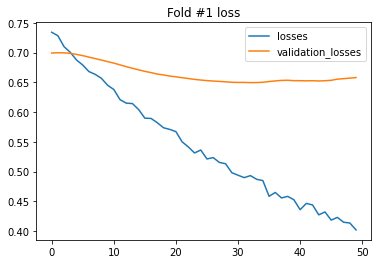

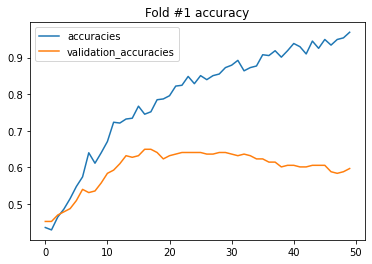

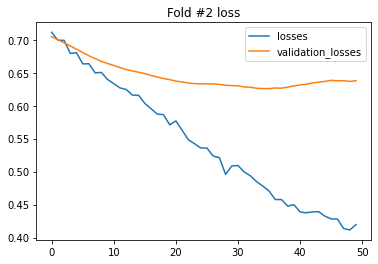

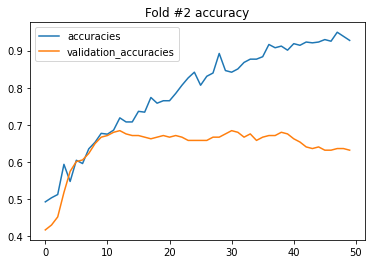

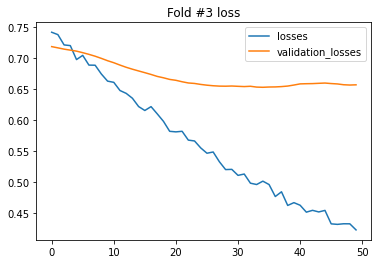

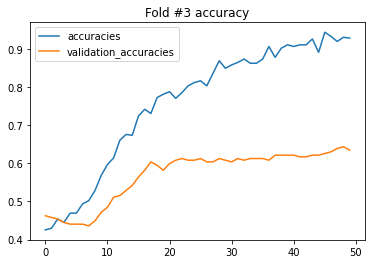

In [ ]:
Kfold(BC_Model_1,3,X_train, y_train, X_test, y_test, 50, optimizer='adam')

In [ ]:
input_shape = X_train.shape[1]
class BC_Model_2(nn.Module):
    def __init__(self):
        super(BC_Model_2,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_shape, 100), # bias=False),
            nn.Flatten(),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Linear(100, 50), # bias=False),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Linear(50, 25, bias=False),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Linear(25,2),
            nn.Softmax(dim=-1)
        )
        
    def forward(self,x):
        return self.layers(x)

In [ ]:
bc_model_2=BC_Model_2()
if torch.cuda.is_available():
    bc_model_2.cuda()
summary(bc_model_2, (1, input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          15,200
           Flatten-2                  [-1, 100]               0
       BatchNorm1d-3                  [-1, 100]             200
              ReLU-4                  [-1, 100]               0
           Dropout-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
       BatchNorm1d-7                   [-1, 50]             100
              ReLU-8                   [-1, 50]               0
           Dropout-9                   [-1, 50]               0
           Linear-10                   [-1, 25]           1,250
      BatchNorm1d-11                   [-1, 25]              50
             ReLU-12                   [-1, 25]               0
          Dropout-13                   [-1, 25]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Fold #1
BC_Model_2 parameters: 21902


 17%|█▋        | 5/30 [00:00<00:00, 46.60it/s]

Epoch 1/30 - Loss: 0.705 - Acc: 0.497
              Val_loss: 0.699 - Val_acc: 0.417


 37%|███▋      | 11/30 [00:00<00:00, 54.04it/s]

Epoch 11/30 - Loss: 0.536 - Acc: 0.840
              Val_loss: 0.634 - Val_acc: 0.662


Epoch 21/30 - Loss: 0.403 - Acc: 0.974
              Val_loss: 0.632 - Val_acc: 0.627
func:'train'  took: 0.5814 sec
Train accuracy: 0.9890109856050093
Validation accuracy: 0.6491228101546305
Test accuracy: 0.6608187099646406
Fold #2


 40%|████      | 12/30 [00:00<00:00, 56.28it/s]

Epoch 1/30 - Loss: 0.708 - Acc: 0.488
              Val_loss: 0.690 - Val_acc: 0.548
Epoch 11/30 - Loss: 0.501 - Acc: 0.877
              Val_loss: 0.638 - Val_acc: 0.592


Epoch 21/30 - Loss: 0.390 - Acc: 0.978
              Val_loss: 0.647 - Val_acc: 0.596
func:'train'  took: 0.5666 sec


Train accuracy: 0.9890109873079992
Validation accuracy: 0.6008771867082829
Test accuracy: 0.6140350919020803
Fold #3


 23%|██▎       | 7/30 [00:00<00:00, 61.94it/s]

Epoch 1/30 - Loss: 0.687 - Acc: 0.531
              Val_loss: 0.690 - Val_acc: 0.559
Epoch 11/30 - Loss: 0.482 - Acc: 0.919
              Val_loss: 0.636 - Val_acc: 0.626


Epoch 21/30 - Loss: 0.397 - Acc: 0.976
              Val_loss: 0.643 - Val_acc: 0.617
func:'train'  took: 0.5211 sec


Train accuracy: 0.9824561393051816
Validation accuracy: 0.6211453867903891
Test accuracy: 0.6374268953563177
Final results:
Training accuracy:0.986826+-0.003090
Testing accuracy:0.637427+-0.019099


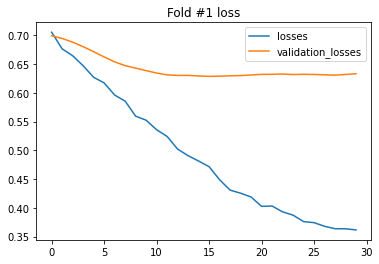

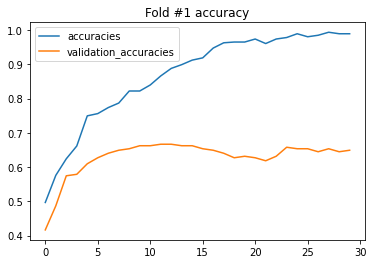

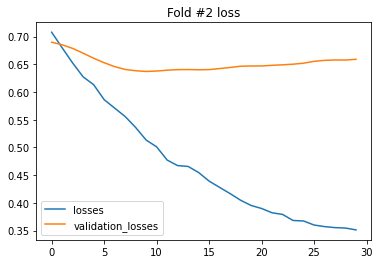

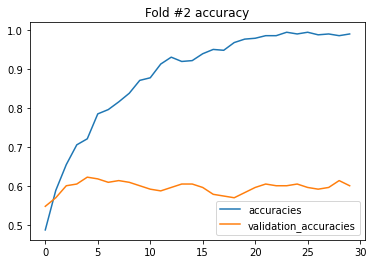

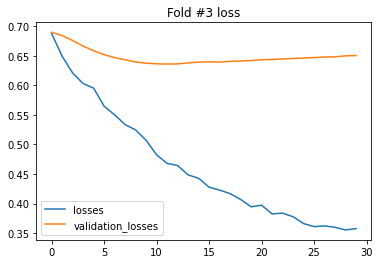

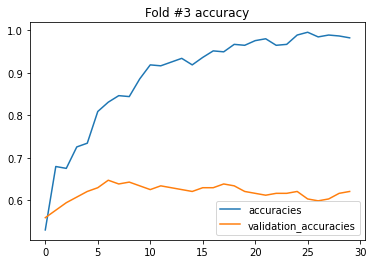

In [ ]:
Kfold(BC_Model_2,3,X_train, y_train, X_test, y_test, 30, optimizer='adam')

In [ ]:
input_size = X_train.shape[1]
class BC_Model_3(nn.Module):
    def __init__(self):
        super(BC_Model_3,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 500), # bias=False),
            nn.Flatten(),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(500, 300), # bias=False),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(300, 100), # bias=False),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(0.25),


            nn.Linear(50,2),
            nn.Softmax(dim=-1)
        )
        
    def forward(self,x):
        return self.layers(x)

In [ ]:
bc_model_3 = BC_Model_3()
if torch.cuda.is_available():
    bc_model_3.cuda()
summary(bc_model_3, (1, input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]          76,000
           Flatten-2                  [-1, 500]               0
       BatchNorm1d-3                  [-1, 500]           1,000
              ReLU-4                  [-1, 500]               0
           Dropout-5                  [-1, 500]               0
            Linear-6                  [-1, 300]         150,300
       BatchNorm1d-7                  [-1, 300]             600
              ReLU-8                  [-1, 300]               0
           Dropout-9                  [-1, 300]               0
           Linear-10                  [-1, 100]          30,100
      BatchNorm1d-11                  [-1, 100]             200
             ReLU-12                  [-1, 100]               0
          Dropout-13                  [-1, 100]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Fold #1
BC_Model_3 parameters: 263452


  4%|▍         | 2/50 [00:00<00:03, 12.55it/s]

Epoch 1/50 - Loss: 0.707 - Acc: 0.519
              Val_loss: 0.681 - Val_acc: 0.610


 24%|██▍       | 12/50 [00:01<00:03, 11.49it/s]

Epoch 11/50 - Loss: 0.437 - Acc: 0.960
              Val_loss: 0.629 - Val_acc: 0.680


 44%|████▍     | 22/50 [00:01<00:02, 11.51it/s]

Epoch 21/50 - Loss: 0.348 - Acc: 0.996
              Val_loss: 0.625 - Val_acc: 0.671


 64%|██████▍   | 32/50 [00:02<00:01, 12.04it/s]

Epoch 31/50 - Loss: 0.337 - Acc: 0.996
              Val_loss: 0.664 - Val_acc: 0.610


 84%|████████▍ | 42/50 [00:03<00:00, 12.54it/s]

Epoch 41/50 - Loss: 0.333 - Acc: 1.000
              Val_loss: 0.643 - Val_acc: 0.662


func:'train'  took: 4.2016 sec
Train accuracy: 1.0
Validation accuracy: 0.6535087698384334
Test accuracy: 0.5964912228416978
Fold #2


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 0.709 - Acc: 0.519
              Val_loss: 0.691 - Val_acc: 0.575


 24%|██▍       | 12/50 [00:00<00:02, 12.74it/s]

Epoch 11/50 - Loss: 0.433 - Acc: 0.945
              Val_loss: 0.647 - Val_acc: 0.632


 48%|████▊     | 24/50 [00:02<00:01, 13.00it/s]

Epoch 21/50 - Loss: 0.347 - Acc: 1.000
              Val_loss: 0.668 - Val_acc: 0.601


 66%|██████▌   | 33/50 [00:02<00:00, 17.78it/s]

Epoch 31/50 - Loss: 0.333 - Acc: 1.000
              Val_loss: 0.668 - Val_acc: 0.627


 88%|████████▊ | 44/50 [00:03<00:00, 19.31it/s]

Epoch 41/50 - Loss: 0.332 - Acc: 1.000
              Val_loss: 0.676 - Val_acc: 0.627


func:'train'  took: 3.6299 sec
Train accuracy: 1.0
Validation accuracy: 0.6228070070869044
Test accuracy: 0.6725146230201275
Fold #3


  4%|▍         | 2/50 [00:00<00:02, 18.53it/s]

Epoch 1/50 - Loss: 0.690 - Acc: 0.610
              Val_loss: 0.688 - Val_acc: 0.529


 26%|██▌       | 13/50 [00:00<00:01, 19.11it/s]

Epoch 11/50 - Loss: 0.422 - Acc: 0.958
              Val_loss: 0.664 - Val_acc: 0.612


 46%|████▌     | 23/50 [00:01<00:01, 18.82it/s]

Epoch 21/50 - Loss: 0.347 - Acc: 0.998
              Val_loss: 0.688 - Val_acc: 0.599


 66%|██████▌   | 33/50 [00:01<00:00, 18.89it/s]

Epoch 31/50 - Loss: 0.335 - Acc: 1.000
              Val_loss: 0.684 - Val_acc: 0.621


 88%|████████▊ | 44/50 [00:02<00:00, 19.45it/s]

Epoch 41/50 - Loss: 0.330 - Acc: 1.000
              Val_loss: 0.681 - Val_acc: 0.608


func:'train'  took: 2.6331 sec
Train accuracy: 1.0
Validation accuracy: 0.5947136541557733
Test accuracy: 0.5730994129390047
Final results:
Training accuracy:1.000000+-0.000000
Testing accuracy:0.614035+-0.042440


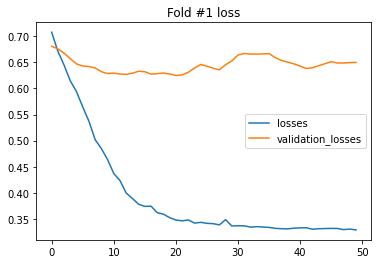

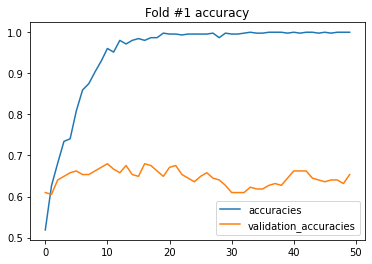

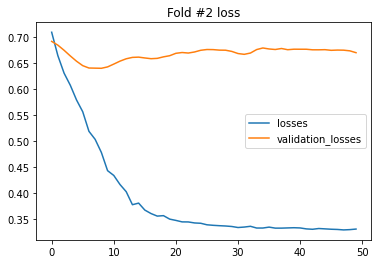

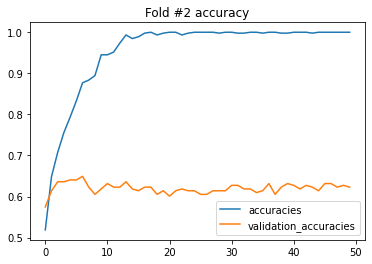

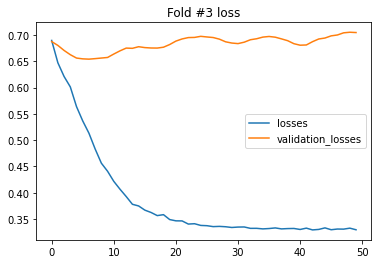

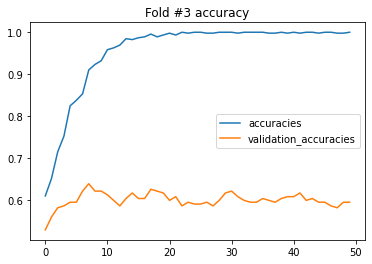

In [ ]:
Kfold(BC_Model_3,3,X_train, y_train, X_test, y_test, 50, optimizer='adam')

In [ ]:
class BC_Model_4(nn.Module):
    def __init__(self):
        super(BC_Model_4, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(50,2),
            nn.Softmax(dim=-1)
        )
        
    def forward(self,x):
        return self.layers(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Fold #1
BC_Model_4 parameters: 7802


 13%|█▎        | 4/30 [00:00<00:00, 37.67it/s]

Epoch 1/30 - Loss: 0.698 - Acc: 0.513
              Val_loss: 0.697 - Val_acc: 0.526


 63%|██████▎   | 19/30 [00:00<00:00, 40.89it/s]

Epoch 11/30 - Loss: 0.541 - Acc: 0.815
              Val_loss: 0.637 - Val_acc: 0.672


Epoch 21/30 - Loss: 0.440 - Acc: 0.927
              Val_loss: 0.641 - Val_acc: 0.664
func:'train'  took: 0.6974 sec


Train accuracy: 0.9725274727458045
Validation accuracy: 0.6277372280176539
Test accuracy: 0.678362566825242
Fold #2


 20%|██        | 6/30 [00:00<00:00, 51.55it/s]

Epoch 1/30 - Loss: 0.698 - Acc: 0.529
              Val_loss: 0.696 - Val_acc: 0.496


 57%|█████▋    | 17/30 [00:00<00:00, 40.52it/s]

Epoch 11/30 - Loss: 0.522 - Acc: 0.866
              Val_loss: 0.638 - Val_acc: 0.686


 90%|█████████ | 27/30 [00:00<00:00, 41.33it/s]

Epoch 21/30 - Loss: 0.429 - Acc: 0.947
              Val_loss: 0.639 - Val_acc: 0.620


func:'train'  took: 0.8172 sec
Train accuracy: 0.9743589743589743
Validation accuracy: 0.6350364980906466
Test accuracy: 0.6549707633710047
Fold #3


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Loss: 0.692 - Acc: 0.533
              Val_loss: 0.686 - Val_acc: 0.526


 20%|██        | 6/30 [00:00<00:00, 47.95it/s]

Epoch 11/30 - Loss: 0.526 - Acc: 0.842
              Val_loss: 0.669 - Val_acc: 0.562

 57%|█████▋    | 17/30 [00:00<00:00, 49.61it/s]


Epoch 21/30 - Loss: 0.436 - Acc: 0.934
              Val_loss: 0.665 - Val_acc: 0.569


func:'train'  took: 0.6772 sec
Train accuracy: 0.967032967032967
Validation accuracy: 0.5839416071446273
Test accuracy: 0.6666666698037532
Fold #4


 17%|█▋        | 5/30 [00:00<00:00, 49.52it/s]

Epoch 1/30 - Loss: 0.694 - Acc: 0.559
              Val_loss: 0.694 - Val_acc: 0.551


 67%|██████▋   | 20/30 [00:00<00:00, 47.66it/s]

Epoch 11/30 - Loss: 0.537 - Acc: 0.835
              Val_loss: 0.651 - Val_acc: 0.625


Epoch 21/30 - Loss: 0.439 - Acc: 0.931
              Val_loss: 0.665 - Val_acc: 0.603


func:'train'  took: 0.6835 sec
Train accuracy: 0.9707495429616088
Validation accuracy: 0.6176470588235294
Test accuracy: 0.6432748569382561
Fold #5


 17%|█▋        | 5/30 [00:00<00:00, 47.67it/s]

Epoch 1/30 - Loss: 0.696 - Acc: 0.554
              Val_loss: 0.686 - Val_acc: 0.551


 50%|█████     | 15/30 [00:00<00:00, 44.04it/s]

Epoch 11/30 - Loss: 0.535 - Acc: 0.832
              Val_loss: 0.641 - Val_acc: 0.625


 87%|████████▋ | 26/30 [00:00<00:00, 39.94it/s]

Epoch 21/30 - Loss: 0.438 - Acc: 0.936
              Val_loss: 0.633 - Val_acc: 0.669


func:'train'  took: 0.7245 sec
Train accuracy: 0.9725776965265082
Validation accuracy: 0.6691176470588235
Test accuracy: 0.6432748541497347
Final results:
Training accuracy:0.971449+-0.002486
Testing accuracy:0.657310+-0.013640


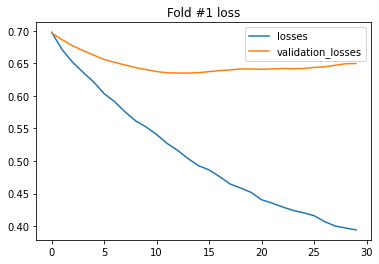

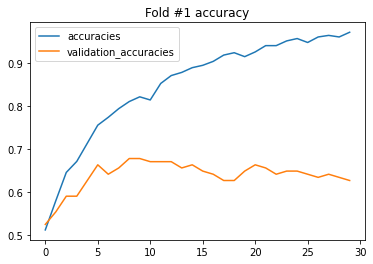

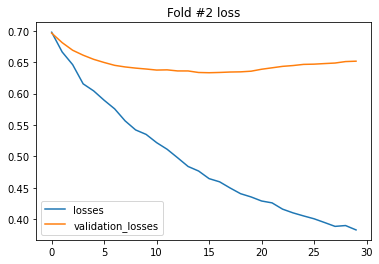

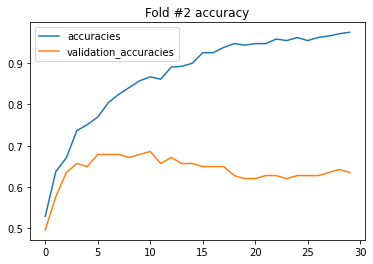

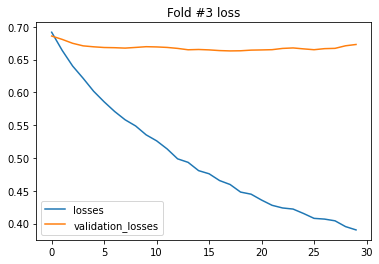

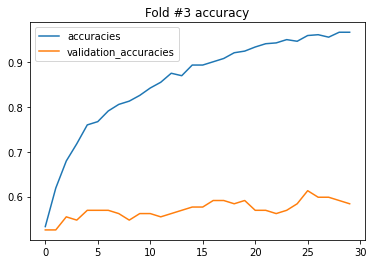

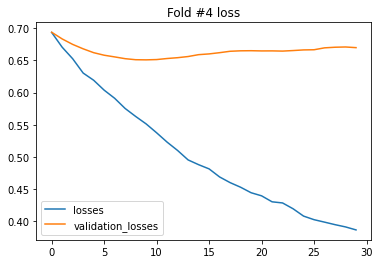

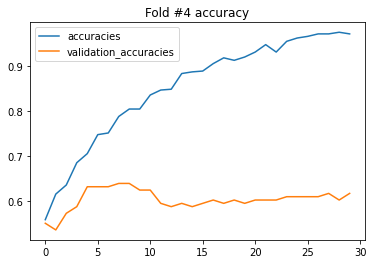

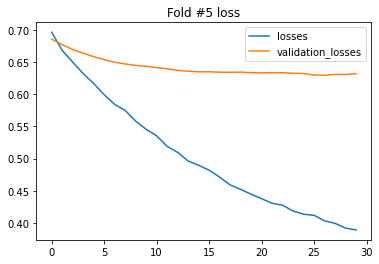

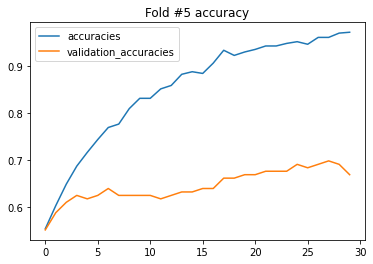

In [ ]:
Kfold(BC_Model_4,5,X_train, y_train, X_test, y_test, 30, optimizer='adam')

In [ ]:
Kfold(BC_Model_4,5,X_train, y_train, X_test, y_test, 50, optimizer='adam', draw_curve=False, lr=1e-4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Fold #1
BC_Model_4 parameters: 7802


  4%|▍         | 2/50 [00:00<00:02, 16.56it/s]

Epoch 1/50 - Loss: 0.691 - Acc: 0.548
              Val_loss: 0.679 - Val_acc: 0.591


 28%|██▊       | 14/50 [00:00<00:02, 14.22it/s]

Epoch 11/50 - Loss: 0.666 - Acc: 0.603
              Val_loss: 0.674 - Val_acc: 0.599


 60%|██████    | 30/50 [00:01<00:00, 32.44it/s]

Epoch 21/50 - Loss: 0.648 - Acc: 0.650
              Val_loss: 0.671 - Val_acc: 0.599


 80%|████████  | 40/50 [00:01<00:00, 40.70it/s]

Epoch 31/50 - Loss: 0.625 - Acc: 0.694
              Val_loss: 0.670 - Val_acc: 0.584
Epoch 41/50 - Loss: 0.611 - Acc: 0.716
              Val_loss: 0.669 - Val_acc: 0.599


func:'train'  took: 1.9105 sec
Train accuracy: 0.7582417595517504
Validation accuracy: 0.576642337506705
Test accuracy: 0.6081871320629677
Fold #2


  8%|▊         | 4/50 [00:00<00:01, 35.37it/s]

Epoch 1/50 - Loss: 0.735 - Acc: 0.447
              Val_loss: 0.733 - Val_acc: 0.438


 38%|███▊      | 19/50 [00:00<00:00, 43.78it/s]

Epoch 11/50 - Loss: 0.708 - Acc: 0.476
              Val_loss: 0.716 - Val_acc: 0.467


 60%|██████    | 30/50 [00:00<00:00, 47.31it/s]

Epoch 21/50 - Loss: 0.679 - Acc: 0.566
              Val_loss: 0.700 - Val_acc: 0.511
Epoch 31/50 - Loss: 0.656 - Acc: 0.641
              Val_loss: 0.687 - Val_acc: 0.547


 92%|█████████▏| 46/50 [00:01<00:00, 47.51it/s]

Epoch 41/50 - Loss: 0.632 - Acc: 0.720
              Val_loss: 0.676 - Val_acc: 0.606


func:'train'  took: 1.1614 sec
Train accuracy: 0.7545787556704148
Validation accuracy: 0.6204379579446612
Test accuracy: 0.6198830357071948
Fold #3


 12%|█▏        | 6/50 [00:00<00:00, 52.36it/s]

Epoch 1/50 - Loss: 0.687 - Acc: 0.546
              Val_loss: 0.696 - Val_acc: 0.482


 36%|███▌      | 18/50 [00:00<00:00, 39.47it/s]

Epoch 11/50 - Loss: 0.673 - Acc: 0.571
              Val_loss: 0.686 - Val_acc: 0.496
Epoch 21/50 - Loss: 0.653 - Acc: 0.592
              Val_loss: 0.679 - Val_acc: 0.518


 80%|████████  | 40/50 [00:00<00:00, 48.33it/s]

Epoch 31/50 - Loss: 0.638 - Acc: 0.634
              Val_loss: 0.672 - Val_acc: 0.547


Epoch 41/50 - Loss: 0.625 - Acc: 0.670
              Val_loss: 0.667 - Val_acc: 0.562
func:'train'  took: 1.1019 sec
Train accuracy: 0.7124542117992164
Validation accuracy: 0.5912408776526904
Test accuracy: 0.5730994127647221
Fold #4


 24%|██▍       | 12/50 [00:00<00:00, 55.29it/s]

Epoch 1/50 - Loss: 0.699 - Acc: 0.559
              Val_loss: 0.673 - Val_acc: 0.566
Epoch 11/50 - Loss: 0.676 - Acc: 0.590
              Val_loss: 0.665 - Val_acc: 0.588


 50%|█████     | 25/50 [00:00<00:00, 53.74it/s]

Epoch 21/50 - Loss: 0.656 - Acc: 0.598
              Val_loss: 0.657 - Val_acc: 0.603


 74%|███████▍  | 37/50 [00:00<00:00, 51.31it/s]

Epoch 31/50 - Loss: 0.642 - Acc: 0.644
              Val_loss: 0.650 - Val_acc: 0.610
Epoch 41/50 - Loss: 0.626 - Acc: 0.660
              Val_loss: 0.644 - Val_acc: 0.610


func:'train'  took: 0.9685 sec
Train accuracy: 0.7038391236849197
Validation accuracy: 0.6397058823529411
Test accuracy: 0.5964912256302192
Fold #5


 10%|█         | 5/50 [00:00<00:00, 45.60it/s]

Epoch 1/50 - Loss: 0.718 - Acc: 0.452
              Val_loss: 0.707 - Val_acc: 0.434


 32%|███▏      | 16/50 [00:00<00:00, 49.89it/s]

Epoch 11/50 - Loss: 0.694 - Acc: 0.523
              Val_loss: 0.694 - Val_acc: 0.463


 52%|█████▏    | 26/50 [00:00<00:00, 44.03it/s]

Epoch 21/50 - Loss: 0.670 - Acc: 0.607
              Val_loss: 0.683 - Val_acc: 0.529


 76%|███████▌  | 38/50 [00:00<00:00, 50.43it/s]

Epoch 31/50 - Loss: 0.648 - Acc: 0.667
              Val_loss: 0.673 - Val_acc: 0.581
Epoch 41/50 - Loss: 0.634 - Acc: 0.718
              Val_loss: 0.665 - Val_acc: 0.596


func:'train'  took: 1.0458 sec
Train accuracy: 0.7550274227393393
Validation accuracy: 0.6176470588235294
Test accuracy: 0.6432748513612133
Final results:
Training accuracy:0.736828+-0.023610
Testing accuracy:0.608187+-0.023392


In [ ]:
class BC_Model_5(nn.Module):
    def __init__(self):
        super(BC_Model_5, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1000),
            nn.ReLU(),
            nn.Linear(1000,50),
            nn.ReLU(),
            nn.Linear(50,2),
            nn.Softmax(dim=-1)
        )
        
    def forward(self,x):
        return self.layers(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Fold #1
BC_Model_5 parameters: 202152


  6%|▌         | 3/50 [00:00<00:01, 28.08it/s]

Epoch 1/50 - Loss: 0.678 - Acc: 0.566
              Val_loss: 0.635 - Val_acc: 0.635


 30%|███       | 15/50 [00:00<00:01, 26.81it/s]

Epoch 11/50 - Loss: 0.348 - Acc: 0.974
              Val_loss: 0.644 - Val_acc: 0.664


 48%|████▊     | 24/50 [00:00<00:00, 26.88it/s]

Epoch 21/50 - Loss: 0.331 - Acc: 0.987
              Val_loss: 0.649 - Val_acc: 0.657


 72%|███████▏  | 36/50 [00:01<00:00, 27.13it/s]

Epoch 31/50 - Loss: 0.330 - Acc: 0.987
              Val_loss: 0.651 - Val_acc: 0.650


 90%|█████████ | 45/50 [00:01<00:00, 26.19it/s]

Epoch 41/50 - Loss: 0.330 - Acc: 0.987
              Val_loss: 0.650 - Val_acc: 0.650


func:'train'  took: 1.8878 sec
Train accuracy: 0.9871794871794872
Validation accuracy: 0.6496350367138856
Test accuracy: 0.6491228112003259
Fold #2


  6%|▌         | 3/50 [00:00<00:01, 25.63it/s]

Epoch 1/50 - Loss: 0.680 - Acc: 0.557
              Val_loss: 0.644 - Val_acc: 0.642


 30%|███       | 15/50 [00:00<00:01, 27.51it/s]

Epoch 11/50 - Loss: 0.349 - Acc: 0.974
              Val_loss: 0.629 - Val_acc: 0.672


 48%|████▊     | 24/50 [00:00<00:00, 26.96it/s]

Epoch 21/50 - Loss: 0.335 - Acc: 0.984
              Val_loss: 0.633 - Val_acc: 0.657


 68%|██████▊   | 34/50 [00:01<00:00, 28.47it/s]

Epoch 31/50 - Loss: 0.334 - Acc: 0.984
              Val_loss: 0.630 - Val_acc: 0.664


 92%|█████████▏| 46/50 [00:01<00:00, 28.26it/s]

Epoch 41/50 - Loss: 0.334 - Acc: 0.984
              Val_loss: 0.631 - Val_acc: 0.664


func:'train'  took: 1.8333 sec
Train accuracy: 0.9835164835164835
Validation accuracy: 0.6642335775124766
Test accuracy: 0.6374268981448391
Fold #3


  6%|▌         | 3/50 [00:00<00:01, 28.71it/s]

Epoch 1/50 - Loss: 0.688 - Acc: 0.579
              Val_loss: 0.676 - Val_acc: 0.533


 30%|███       | 15/50 [00:00<00:01, 28.47it/s]

Epoch 11/50 - Loss: 0.346 - Acc: 0.984
              Val_loss: 0.648 - Val_acc: 0.628


 48%|████▊     | 24/50 [00:00<00:00, 27.75it/s]

Epoch 21/50 - Loss: 0.327 - Acc: 0.991
              Val_loss: 0.665 - Val_acc: 0.620


 72%|███████▏  | 36/50 [00:01<00:00, 27.89it/s]

Epoch 31/50 - Loss: 0.325 - Acc: 0.993
              Val_loss: 0.655 - Val_acc: 0.642


 90%|█████████ | 45/50 [00:01<00:00, 26.85it/s]

Epoch 41/50 - Loss: 0.325 - Acc: 0.993
              Val_loss: 0.652 - Val_acc: 0.650


func:'train'  took: 1.8319 sec
Train accuracy: 0.9926739926739927
Validation accuracy: 0.6350364976555761
Test accuracy: 0.6198830395414118
Fold #4


  6%|▌         | 3/50 [00:00<00:01, 24.20it/s]

Epoch 1/50 - Loss: 0.672 - Acc: 0.594
              Val_loss: 0.651 - Val_acc: 0.625


 30%|███       | 15/50 [00:00<00:01, 26.59it/s]

Epoch 11/50 - Loss: 0.337 - Acc: 0.987
              Val_loss: 0.610 - Val_acc: 0.669


 48%|████▊     | 24/50 [00:00<00:00, 26.67it/s]

Epoch 21/50 - Loss: 0.329 - Acc: 0.989
              Val_loss: 0.608 - Val_acc: 0.684


 72%|███████▏  | 36/50 [00:01<00:00, 25.94it/s]

Epoch 31/50 - Loss: 0.328 - Acc: 0.989
              Val_loss: 0.606 - Val_acc: 0.706


 90%|█████████ | 45/50 [00:01<00:00, 27.31it/s]

Epoch 41/50 - Loss: 0.328 - Acc: 0.989
              Val_loss: 0.605 - Val_acc: 0.706


func:'train'  took: 1.8999 sec
Train accuracy: 0.9890310786106032
Validation accuracy: 0.7058823529411765
Test accuracy: 0.6608187110103362
Fold #5


  6%|▌         | 3/50 [00:00<00:01, 26.20it/s]

Epoch 1/50 - Loss: 0.685 - Acc: 0.537
              Val_loss: 0.666 - Val_acc: 0.559


 30%|███       | 15/50 [00:00<00:01, 26.98it/s]

Epoch 11/50 - Loss: 0.348 - Acc: 0.978
              Val_loss: 0.635 - Val_acc: 0.654


 48%|████▊     | 24/50 [00:00<00:00, 27.28it/s]

Epoch 21/50 - Loss: 0.333 - Acc: 0.984
              Val_loss: 0.647 - Val_acc: 0.640


 72%|███████▏  | 36/50 [00:01<00:00, 27.58it/s]

Epoch 31/50 - Loss: 0.332 - Acc: 0.985
              Val_loss: 0.643 - Val_acc: 0.640


 90%|█████████ | 45/50 [00:01<00:00, 27.21it/s]

Epoch 41/50 - Loss: 0.332 - Acc: 0.985
              Val_loss: 0.644 - Val_acc: 0.632


func:'train'  took: 1.8768 sec
Train accuracy: 0.9872029250457038
Validation accuracy: 0.6470588235294117
Test accuracy: 0.6315789477169862
Final results:
Training accuracy:0.987921+-0.002976
Testing accuracy:0.639766+-0.014132


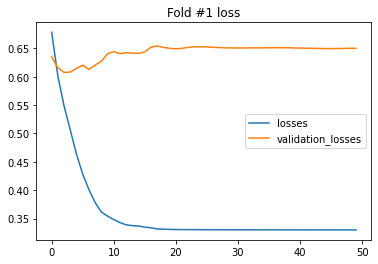

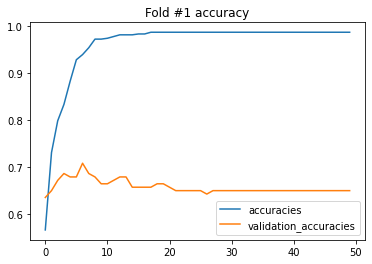

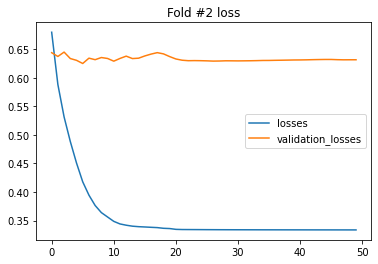

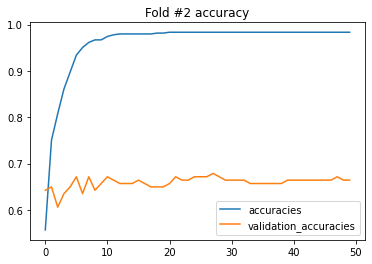

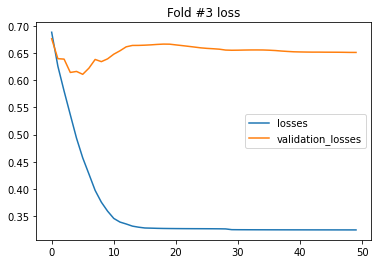

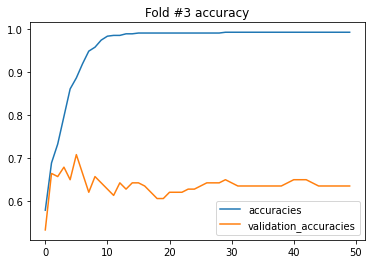

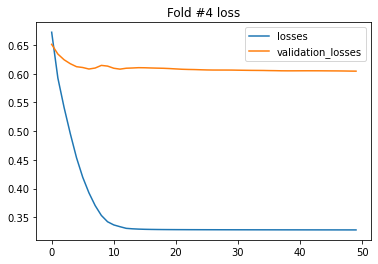

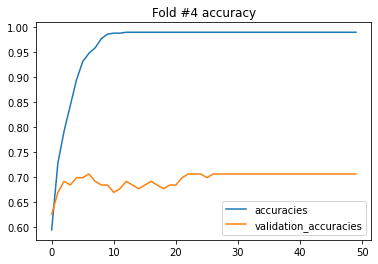

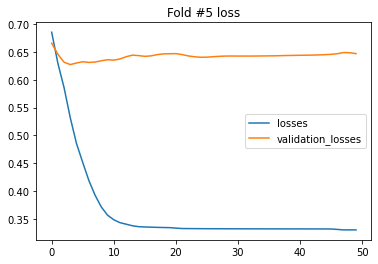

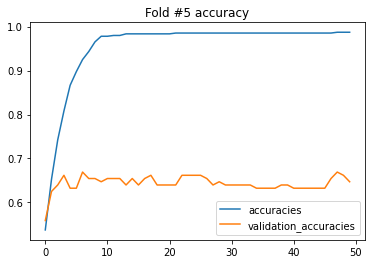

In [ ]:
Kfold(BC_Model_5,5,X_train, y_train, X_test, y_test, 50, optimizer='adam')

In [ ]:
class BC_Model_6(nn.Module):
    def __init__(self):
        super(BC_Model_6, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(10,50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(50,2),
            nn.Softmax(dim=-1)
        )
        
    def forward(self,x):
        return self.layers(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Fold #1
BC_Model_6 parameters: 2292


 16%|█▌        | 8/50 [00:00<00:00, 72.39it/s]

Epoch 1/50 - Loss: 0.726 - Acc: 0.434
              Val_loss: 0.713 - Val_acc: 0.453
Epoch 11/50 - Loss: 0.605 - Acc: 0.725
              Val_loss: 0.674 - Val_acc: 0.599


 62%|██████▏   | 31/50 [00:00<00:00, 67.19it/s]

Epoch 21/50 - Loss: 0.504 - Acc: 0.833
              Val_loss: 0.700 - Val_acc: 0.547
Epoch 31/50 - Loss: 0.427 - Acc: 0.912
              Val_loss: 0.738 - Val_acc: 0.489


Epoch 41/50 - Loss: 0.388 - Acc: 0.947
              Val_loss: 0.763 - Val_acc: 0.474
func:'train'  took: 0.7537 sec
Train accuracy: 0.932234430706108
Validation accuracy: 0.49635036561610923
Test accuracy: 0.6257310000776547
Fold #2


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 0.708 - Acc: 0.449
              Val_loss: 0.688 - Val_acc: 0.555


 16%|█▌        | 8/50 [00:00<00:00, 71.48it/s]

Epoch 11/50 - Loss: 0.624 - Acc: 0.718
              Val_loss: 0.644 - Val_acc: 0.686


 48%|████▊     | 24/50 [00:00<00:00, 68.44it/s]

Epoch 21/50 - Loss: 0.515 - Acc: 0.830
              Val_loss: 0.609 - Val_acc: 0.672


 62%|██████▏   | 31/50 [00:00<00:00, 67.87it/s]

Epoch 31/50 - Loss: 0.427 - Acc: 0.916
              Val_loss: 0.591 - Val_acc: 0.708


 76%|███████▌  | 38/50 [00:00<00:00, 66.56it/s]

Epoch 41/50 - Loss: 0.398 - Acc: 0.941
              Val_loss: 0.598 - Val_acc: 0.679


func:'train'  took: 0.7667 sec
Train accuracy: 0.9578754561288017
Validation accuracy: 0.7007299283125105
Test accuracy: 0.5380116973006934
Fold #3


 16%|█▌        | 8/50 [00:00<00:00, 72.36it/s]

Epoch 1/50 - Loss: 0.702 - Acc: 0.487
              Val_loss: 0.694 - Val_acc: 0.533
Epoch 11/50 - Loss: 0.598 - Acc: 0.723
              Val_loss: 0.662 - Val_acc: 0.591


 64%|██████▍   | 32/50 [00:00<00:00, 68.36it/s]

Epoch 21/50 - Loss: 0.489 - Acc: 0.857
              Val_loss: 0.666 - Val_acc: 0.620
Epoch 31/50 - Loss: 0.427 - Acc: 0.916
              Val_loss: 0.661 - Val_acc: 0.642


Epoch 41/50 - Loss: 0.386 - Acc: 0.951
              Val_loss: 0.666 - Val_acc: 0.642
func:'train'  took: 0.7424 sec
Train accuracy: 0.9597069601436238
Validation accuracy: 0.6423357672934984
Test accuracy: 0.5730994138104176
Fold #4


 30%|███       | 15/50 [00:00<00:00, 70.66it/s]

Epoch 1/50 - Loss: 0.691 - Acc: 0.556
              Val_loss: 0.692 - Val_acc: 0.500
Epoch 11/50 - Loss: 0.604 - Acc: 0.729
              Val_loss: 0.656 - Val_acc: 0.588


 62%|██████▏   | 31/50 [00:00<00:00, 71.88it/s]

Epoch 21/50 - Loss: 0.502 - Acc: 0.852
              Val_loss: 0.644 - Val_acc: 0.632
Epoch 31/50 - Loss: 0.423 - Acc: 0.932
              Val_loss: 0.646 - Val_acc: 0.618


Epoch 41/50 - Loss: 0.385 - Acc: 0.951
              Val_loss: 0.656 - Val_acc: 0.603
func:'train'  took: 0.7166 sec
Train accuracy: 0.9652650824848433
Validation accuracy: 0.6470588235294117
Test accuracy: 0.6257309917120906
Fold #5


 16%|█▌        | 8/50 [00:00<00:00, 73.12it/s]

Epoch 1/50 - Loss: 0.706 - Acc: 0.464
              Val_loss: 0.703 - Val_acc: 0.471
Epoch 11/50 - Loss: 0.600 - Acc: 0.726
              Val_loss: 0.663 - Val_acc: 0.559


 62%|██████▏   | 31/50 [00:00<00:00, 68.07it/s]

Epoch 21/50 - Loss: 0.504 - Acc: 0.846
              Val_loss: 0.644 - Val_acc: 0.588
Epoch 31/50 - Loss: 0.442 - Acc: 0.901
              Val_loss: 0.630 - Val_acc: 0.625


Epoch 41/50 - Loss: 0.404 - Acc: 0.932
              Val_loss: 0.642 - Val_acc: 0.610
func:'train'  took: 0.7487 sec
Train accuracy: 0.9469835471627481
Validation accuracy: 0.6397058823529411
Test accuracy: 0.6257309889235692
Final results:
Training accuracy:0.952413+-0.011704
Testing accuracy:0.597661+-0.036125


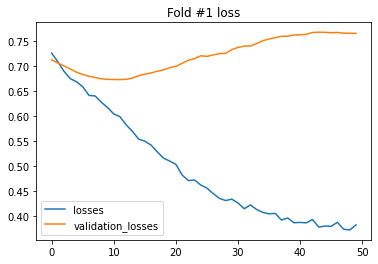

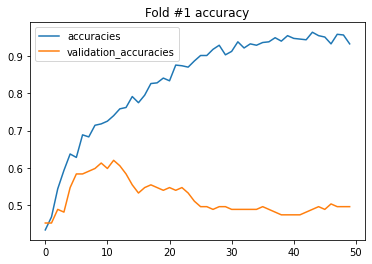

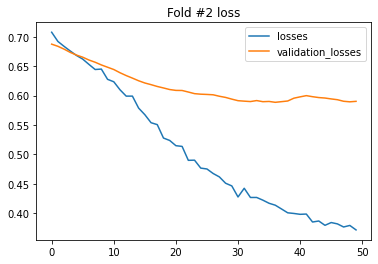

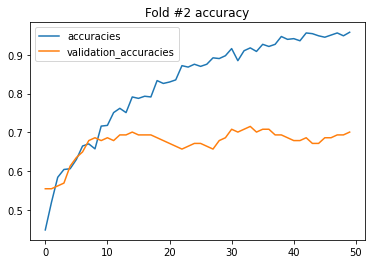

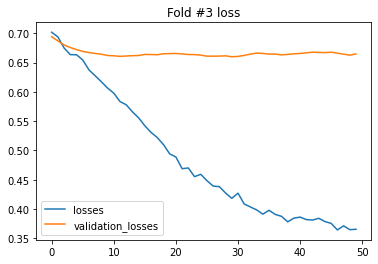

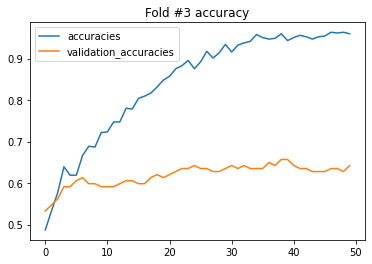

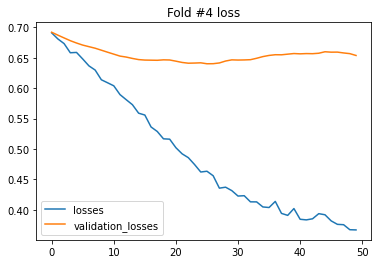

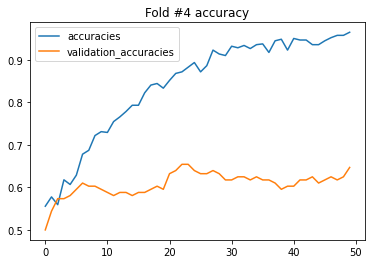

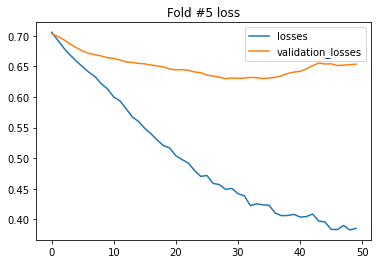

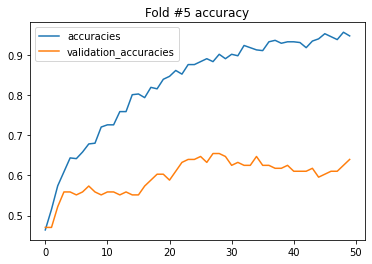

In [ ]:
Kfold(BC_Model_6,5,X_train, y_train, X_test, y_test, 50, optimizer='adam')

# Conclusions:
### As one can see, The simplest ANN introduced performed best, and ANN testing accuracy usually ranged from 0.6-0.65, which is generally poorer than predictions by the simpler models examined in Part 1. It seems as if the issue is with the dataset itself, in that we are not actually able to predict survival well based off of the features contained in the dataset. 

### In fact, two models in published papers (Jing et al., 2019 and Katzman et al., 2018) achieved performance similar to mine on the METABRIC dataset, providing further evidence of this.

### To improve the data, feature engineering could be helpful. Clinical data tended to be most predictive, which makes sense since that data focused on actual features of the patient's cancer, as well as choices in how the patient and medical team chose to treat the disease. Furthermore, differential gene expression (measured by mRNA Z-scores) and mutations probably played a large role in cancer development, but the dataset focused on patients once they had already been diagnosed.

### To improve the predictive power of this dataset, there should be a greater focus on clinical features. The dataset gives very little data on the details of a patient's treatment. For example, it does not give any further information on chemetherapy, other than to say if the patient had it, when dosages, treatment frequencies, etc could vary greatly. In addition, social factors, such as socioeconmic status, factor into cancer survival, and this was not included in the dataset. Finally, other factors, such as patient outlook and social support network could also play a significant role and may be helpful to include.